In [347]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
import nltk
import re
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from unidecode import unidecode
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from scipy.linalg import svd


with open('testdata.txt', 'r') as file:
    # Read the entire contents of the file
    content = file.read()

# Split the content into sentences using punctuation + newline as separators
sentences = re.split(r'[.!?]\s*\n', content)

# Strip leading and trailing whitespaces from each sentence
array_of_sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lycko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lycko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [348]:
# document preprocessing

#Load list of stop words , 851 words
with open('stop_words_english.txt', 'r') as file:
    content = file.read()
stop_words = set(content.split("\n"))
#stop_words.extend(['matrix', 'eigenvalue','vector', 'eigenvector'])


#Create stemmer instance
stemmer = SnowballStemmer("english")

# Store final preprocessed data set in 'corpus'
corpus = [] 

for sentence in array_of_sentences:

    # Remove non-alphabetic characters and numbers
    sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)
    
    # Tokenize the sentence into words
    words = sentence.split()

    # Remove stopwords and apply stemming to each word
    processed_words = [stemmer.stem(word) for word in words if word.lower() not in stop_words]

    # Join the processed words to form the processed sentence
    processed_sentence = ' '.join(processed_words)

    # Append the processed sentence to the list
    corpus.append(processed_sentence)

array_corpus = np.array(corpus)

In [349]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the processed sentences to obtain the sparse TF-IDF matrix (This is our matrix A)
# Also transpose the matrix
tfidf_matrix = vectorizer.fit_transform(array_corpus).T

# Convert the TF-IDF matrix to a dense NumPy array
dense_tfidf_matrix = tfidf_matrix.toarray()

# Get all terms
array_of_terms = vectorizer.get_feature_names()


In [350]:
# perform SVD
u, s, v = svd(dense_tfidf_matrix,full_matrices=False) 

#Some of the components of the vectors are negative!! In the book it says that they should not
#Using abs seem to give good result
u1 = abs(u[:,0]) 
v1 = abs(v[0,:])

# Extract the most important sentences and terms
most_important_terms_indices = np.argsort(u1)[::-1] #[::-1] = reversing the list because argsort choose ascending order

most_important_sentences_indices = np.argsort(v1)[::-1] #[::-1] = reversing the list because argsort choose ascending order

# Get the actual sentences and terms
most_important_sentences = [array_of_sentences[i] for i in most_important_sentences_indices]
most_important_terms = [array_of_terms[i] for i in most_important_terms_indices]

# Print the results

print("\nTop most important terms:")
for term in most_important_terms[0:5]:
    print(term)
print("\n")

print("Top most important sentences:")
for sentence in most_important_sentences[0:5]:
    print(sentence)
print(most_important_sentences_indices[0:5])


Top most important terms:
christma
tree
hope
await
claus


Top most important sentences:
Children eagerly await Santa Claus, hoping to find presents under the tree on Christmas morning
The twinkling lights on the Christmas tree illuminate the room, casting a warm glow that symbolizes hope and togetherness
Eggnog, a traditional Christmas beverage, is often enjoyed by the fireplace while singing carols with loved ones
During the holiday season, snowflakes gently fall, creating a magical atmosphere that enhances the Christmas spirit
Celebrate Christmas with joy and festive decorations, as families come together to exchange gifts and share delicious meals
[6 5 4 1 0]


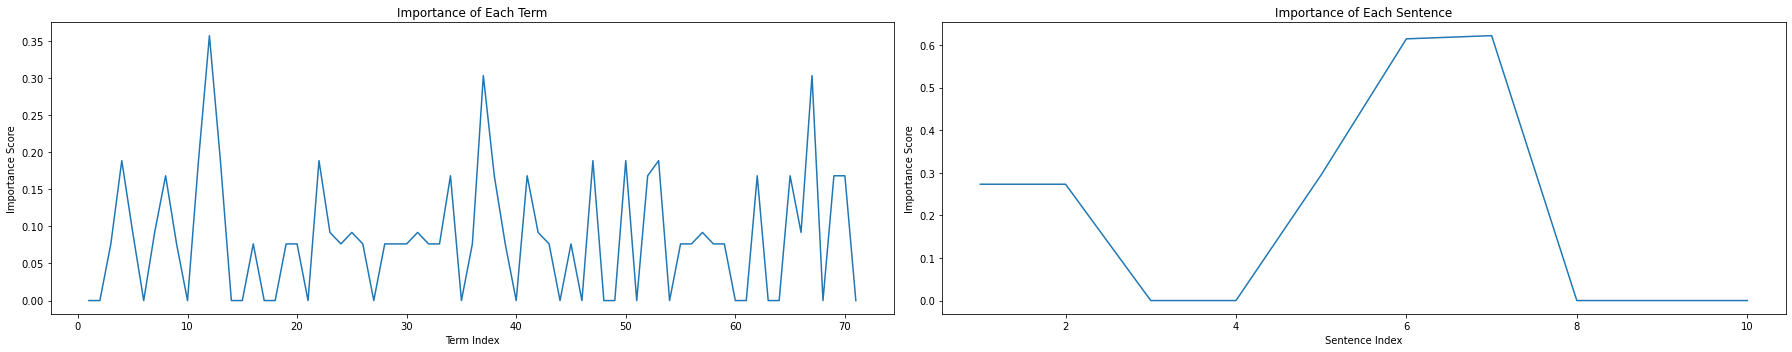

In [351]:
# Plot the importance of each term
plt.figure(figsize=(25, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(u1) + 1), u1)
plt.title('Importance of Each Term')
plt.xlabel('Term Index')
plt.ylabel('Importance Score')

# Plot the importance of each sentence
plt.subplot(1, 2, 2)
plt.plot(range(1, len(v1) + 1), v1)
plt.title('Importance of Each Sentence')
plt.xlabel('Sentence Index')
plt.ylabel('Importance Score')

plt.tight_layout()
plt.show()

In [352]:
#Rank k using QR decomposition with column pivoting
import numpy as np
from scipy.linalg import qr

k = 9

# Assuming D is your TF-IDF matrix
u, s, v = svd(dense_tfidf_matrix, full_matrices=False) #Returns with k = min(m,n)

u = u[:,k]
v = v[k,:]
s = s[:k]


D = (s[:,None]*v) 

# QR decomposition with column pivoting
Q, R, P = qr(D, pivoting=True)

# Compute the indices of the first k columns of AP
n = D.shape[1]

p = np.arange(1, n + 1) @ np.eye(n)[:, P].astype(int)
p = p[:,None]
#print(p.shape)

pk = []
for index in p[:k]:
    pk.append(index[0]-1) #-1 because when we create p, first index is 1

print(pk)
most_important_sentences = []
for index in pk:
    most_important_sentences.append(array_of_sentences[index])

for sentence in most_important_sentences:
    print(sentence)

#Notice that this list is very similar to our SVD version, but reversed (if k = 9)
#Differnt k give very different result

[7, 1, 2, 3, 4, 5, 6, 0, 8]
In and of the, a, to, is, with
During the holiday season, snowflakes gently fall, creating a magical atmosphere that enhances the Christmas spirit
By the time he arrived at the office, it was already late in the day, and most colleagues had gone home
Despite the challenges faced, the team managed to successfully complete the project ahead of schedule
Eggnog, a traditional Christmas beverage, is often enjoyed by the fireplace while singing carols with loved ones
The twinkling lights on the Christmas tree illuminate the room, casting a warm glow that symbolizes hope and togetherness
Children eagerly await Santa Claus, hoping to find presents under the tree on Christmas morning
Celebrate Christmas with joy and festive decorations, as families come together to exchange gifts and share delicious meals
On the way to the store, she decided to buy some groceries for dinner
